In [1]:
import os
import sys

path = '/home/seq/pelenet'
sys.path.append(path)
os.chdir(path)

In [2]:
# Allow reload of objects
%load_ext autoreload
%autoreload

from pelenet.utils import Utils
from pelenet.experiments.assemblies import AssemblyExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy
import statsmodels.api as sm
from nxsdk.logutils.nxlogging import LoggingLevel

In [3]:
# Overwrite default parameters (pelenet/parameters/ and pelenet/experiments/random.py)
parameters = {
    'loihiLoggingLevel': LoggingLevel.ERROR,
    # Experiment
    'seed': 1,  # Random seed
    'trials': 40, #20,  # Number of trials
    'stepsPerTrial': 40, #50,  # Number of simulation steps for every trial
    'isReset': True,  # Activate reset after every trial
    # Network
    'reservoirExSize': 400,  # Number of excitatory neurons
    'reservoirConnPerNeuron': 35, #35 # Number of connections per neuron
    # Noise
    'isNoise': True,
    'onlyExcitatory': True,  # Noisy input is only excitatory
    'noiseMaxWeight': 120, #120,
    # Neurons
    'refractoryDelay': 2, # Refactory period
    'voltageTau': 100, #100 # Voltage time constant
    'currentTau': 6, #5 # Current time constant
    'thresholdMant': 1200, #1200  # Spiking threshold for membrane potential
    # Plasticity
    'isLearningRule': True,
    'learningEpoch': 4,
    'learningRule': '2^-2*x1*y0 - 2^-2*y1*x0 + 2^-4*x1*y1*x0*y0 - 2^-3*y0*w*w', #'2^-2*x1*y0 - 2^-2*y1*x0 + 2^-4*x1*y1*y0 - 2^-3*y0*w*w',
    #'learningRule': '2^-3*x1*y1*x0*y0 - 2^-3*y0*w*w',
    #'learningRule': '2^-2*x1*y0 - 2^-2*y1*x0 + 2^-3*y0*w*w',
    # Input
    'inputIsVary': True,
    'inputOffset': 10,
    'inputVaryProbs': [0.1, 0.9],
    'inputGenSpikeProb': 0.8,  # Probability of spikes for the spike generators
    'inputNumTargetNeurons': 40,  # Number of neurons targeted by the spike generators
    'inputSteps': 20, #30,  # Number of steps the input is active
    # Probes
    'isExSpikeProbe': True,  # Probe excitatory spikes
    'isInSpikeProbe': True,  # Probe inhibitory spikes
    'isWeightProbe': True  # Probe weight matrix at the end of the simulation
}

In [4]:
def calc_error(x, y, trials):
    x_err = []
    for i in range(trials):
        # Estimate
        model = sm.OLS(y, x[i].T)
        params = model.fit().params

        # Predict
        ye = np.dot(x[i].T, params)
        err = np.sqrt(np.sum(np.square(y-ye)))
        x_err.append(err)
    return x_err

In [5]:
supports = []

a_y = np.sin(np.arange(20)/10*(np.pi))
b_y = np.cos(np.arange(20)/10*(np.pi))

def run_epoch(seed):
    p = deepcopy(parameters)
    print(seed)
    p['seed'] = seed
    
    """
    Allocation
    """
    # Initilizes the experiment and utils
    exp = AssemblyExperiment(name='assemblies', parameters=p)
    utils = Utils.instance()
    
    # Build network
    exp.build()

    # Get spectral radius
    #utils.getSpectralRadius(exp.net.initialWeights)
    
    # Run network
    exp.run()
    
    supportMasks = utils.getSupportMasksForAllTrials(exp.net.initialWeights.exex, exp.net.trainedWeightsExex)
    
    #0: A, 1: B, 2: others
    a_masks = np.array([ supportMasks[i, 0] for i in range(exp.net.p.trials) ])
    b_masks = np.array([ supportMasks[i, 1] for i in range(exp.net.p.trials) ])
    
    backgroundNeurons = exp.net.exSpikeTrains[80:]
    
    a_x = [ backgroundNeurons[a_masks[i],40+i*60:(i+1)*60] for i in range(exp.net.p.trials) ]
    b_x = [ backgroundNeurons[b_masks[i],40+i*60:(i+1)*60] for i in range(exp.net.p.trials) ]
    
    err_al = np.array([calc_error(a_x, a_y, exp.net.p.trials), calc_error(b_x, b_y, exp.net.p.trials)])
    
    """
    Reallocation
    """
    # New parameters
    newParameters = {
        **p,
        'trials': 40,
        'inputVaryProbs': [0.9, 0.1]
    }
    
    # Initilizes a second experiment
    exp2 = AssemblyExperiment(name='assemblies-retrain', parameters=newParameters)

    # Build network
    weights = deepcopy(exp.net.initialWeights)
    weights.exex = exp.net.trainedWeightsExex[-1]
    exp2.build(exp.net.initialMasks, weights)

    # Run network
    exp2.run()
    
    # Get support masks
    supportMasks2 = utils.getSupportMasksForAllTrials(exp2.net.initialWeights.exex, exp2.net.trainedWeightsExex)
    
    #0: A, 1: B, 2: others
    a_masks = np.array([ supportMasks2[i, 0] for i in range(exp2.net.p.trials) ])
    b_masks = np.array([ supportMasks2[i, 1] for i in range(exp2.net.p.trials) ])
    
    backgroundNeurons = exp2.net.exSpikeTrains[80:]
    
    a_x = [ backgroundNeurons[a_masks[i],40+i*60:(i+1)*60] for i in range(exp2.net.p.trials) ]
    b_x = [ backgroundNeurons[b_masks[i],40+i*60:(i+1)*60] for i in range(exp2.net.p.trials) ]
    
    err_re = np.array([calc_error(a_x, a_y, exp2.net.p.trials), calc_error(b_x, b_y, exp2.net.p.trials)])
    
    return np.array([err_al, err_re])

In [6]:
errs = np.array([run_epoch(i) for i in range(10)])

0
1   Processing timeseries... .. 
2   Processing timeseries... .. 
3   Processing timeseries... .. 
4   Processing timeseries... .. 
5   Processing timeseries... .. 
6   Processing timeseries... .. 
7   Processing timeseries... .. 
8   Processing timeseries... .. 
9   Processing timeseries... .. 


In [7]:
err_means = np.mean(errs, axis=0)
err_al = err_means[0]
err_re = err_means[1]

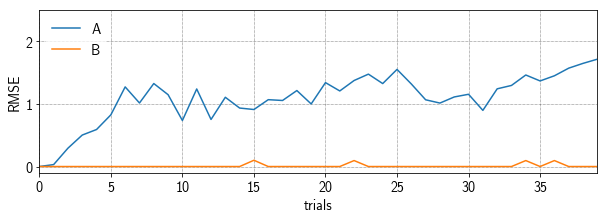

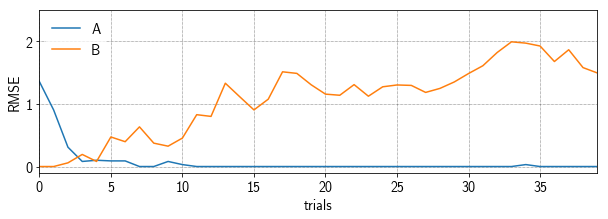

In [8]:
plt.figure(figsize=(10,3))
plt.plot(err_al[0], label='A')
plt.plot(err_al[1], label='B')
plt.xlim(0,39)
plt.ylim(-0.1,2.5)
plt.xlabel('trials')
plt.ylabel('RMSE')
plt.legend()
pl = plt.show()

plt.figure(figsize=(10,3))
plt.plot(err_re[0], label='A')
plt.plot(err_re[1], label='B')
plt.xlim(0,39)
plt.ylim(-0.1,2.5)
plt.xlabel('trials')
plt.ylabel('RMSE')
plt.legend()
pl = plt.show()